In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
from prophet import Prophet
from openpyxl.workbook import Workbook
from matplotlib import pyplot as plt
from prophet.plot import plot_plotly, plot_components_plotly
import plotly.express as px
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
import cx_Oracle
from config import oracle_wfm_key
import time
import datetime as dt
from sqlalchemy import create_engine
from sqlalchemy.engine import URL
from sqlalchemy.types import String
import ipynbname
from tqdm import tqdm
import itertools
import databases as db

ods = db.oracle('cco_wfm',oracle_wfm_key)

file = ipynbname.name()
output_path=r'\\Tds\Metrocom\Contact Center\Workforce Management\Forecasting Models\Forecast Outputs\\'

In [2]:
service = ['Wireline Retention QCB','Wireline Consumer Triage','Wireline Consumer Specialist']
yesterday = dt.date.today() - dt.timedelta(days=1)
appended_data = []
for name in service:
    query = f'''SELECT "A1"."DateTime",
                "A1"."Queue",
                "A1"."Forecasted_AHT",
                "A1"."Forecasted_CV",
                "A1"."Actual_AHT",
                "A1"."Actual_CV"
        FROM "CCO_WFM"."Queue_Analytics" "A1"
        WHERE "A1"."Queue" = '{name}'
            AND "A1"."DateTime" <= TO_DATE('{yesterday}','YYYY-MM-DD')'''
    data = pd.read_sql(query, ods)
    appended_data.append(data)
appended_data = pd.concat(appended_data)
appended_data.head(3)

DateTime                   Queue  Forecasted_AHT  Forecasted_CV  \
0 2022-10-09 00:00:00  Wireline Retention QCB             NaN            NaN   
1 2022-10-09 00:15:00  Wireline Retention QCB             NaN            NaN   
2 2022-10-09 00:30:00  Wireline Retention QCB             NaN            NaN   

   Actual_AHT  Actual_CV  
0         0.0        0.0  
1         0.0        0.0  
2         0.0        0.0

## Volume Forecasts

In [3]:
grouped_cv = appended_data.groupby(['DateTime'])['Actual_CV'].sum()
grouped_cv = grouped_cv.reset_index()
grouped_cv.head(3)

DateTime  Actual_CV
0 2017-01-02 07:00:00        0.0
1 2017-01-02 07:15:00        0.0
2 2017-01-02 07:30:00        1.0

In [4]:
hourly_cv = grouped_cv.resample('1H', on='DateTime').sum()
hourly_cv.head(3)

Actual_CV
DateTime                      
2017-01-02 07:00:00        2.0
2017-01-02 08:00:00       18.0
2017-01-02 09:00:00       51.0

In [5]:
grouped_fcv = appended_data.groupby(['DateTime'])['Forecasted_CV'].sum()
grouped_fcv = grouped_fcv.reset_index()
grouped_fcv.head(3)

DateTime  Forecasted_CV
0 2017-01-02 07:00:00            3.0
1 2017-01-02 07:15:00            2.0
2 2017-01-02 07:30:00            3.0

In [6]:
hourly_fcv = grouped_fcv.resample('1H', on='DateTime').sum()
hourly_fcv.head(3)

Forecasted_CV
DateTime                          
2017-01-02 07:00:00           12.0
2017-01-02 08:00:00           16.0
2017-01-02 09:00:00           26.0

In [7]:
hourly_cv.reset_index(inplace=True)
daily_cv = hourly_cv.resample('D', on='DateTime').sum()
daily_cv.head(3)

Actual_CV
DateTime             
2017-01-02      272.0
2017-01-03      391.0
2017-01-04      304.0

In [8]:
hourly_fcv.reset_index(inplace=True)
daily_fcv = hourly_fcv.resample('D', on='DateTime').sum()
daily_fcv.head(3)

Forecasted_CV
DateTime                 
2017-01-02          209.0
2017-01-03          336.0
2017-01-04          277.0

In [9]:
daily_cv.reset_index(inplace=True)
weekly_cv = daily_cv.resample('W', label='left', on='DateTime').sum()
weekly_cv.tail(3)

Actual_CV
DateTime             
2022-10-23     6860.0
2022-10-30     6287.0
2022-11-06     1370.0

In [10]:
daily_fcv.reset_index(inplace=True)
weekly_fcv = daily_fcv.resample('W', label='left', on='DateTime').sum()
weekly_fcv.tail(3)

Forecasted_CV
DateTime                 
2022-10-23         6481.0
2022-10-30         6680.0
2022-11-06         1490.0

In [11]:
column_names = ['ds','for_y']
weekly_for = weekly_fcv.reset_index()
weekly_for.columns = column_names
weekly_for = weekly_for.replace(0,np.nan)
weekly_for.tail(3)

ds   for_y
303 2022-10-23  6481.0
304 2022-10-30  6680.0
305 2022-11-06  1490.0

In [12]:
column_names = ['ds','y']
weekly_data = weekly_cv.reset_index()
weekly_data.columns = column_names
weekly_data = weekly_data.replace(0,np.nan)
weekly_data.tail(3)

ds       y
303 2022-10-23  6860.0
304 2022-10-30  6287.0
305 2022-11-06  1370.0

#### Initiate Prophet

In [13]:
df = weekly_data
m = Prophet() 
m.fit(df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [14]:
future = m.make_future_dataframe(periods=104, freq='W')
future.tail(3)

ds
407 2024-10-20
408 2024-10-27
409 2024-11-03

In [15]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(3)


ds         yhat   yhat_lower   yhat_upper
407 2024-10-20  7160.111193  6511.420117  7870.254820
408 2024-10-27  6925.949552  6198.030383  7616.850995
409 2024-11-03  6544.523137  5837.384989  7299.485011

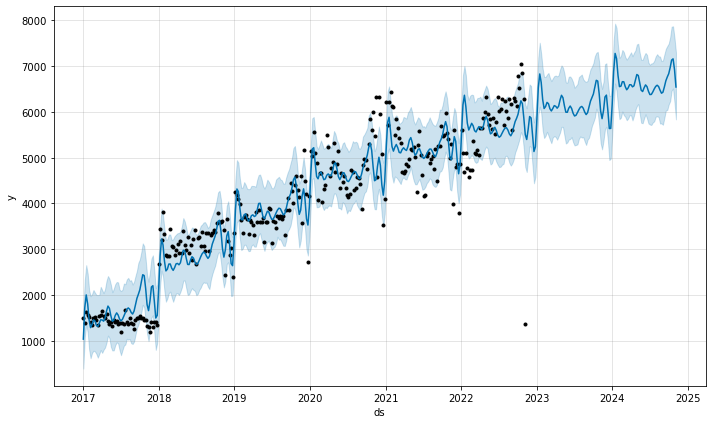

In [16]:
fig1 = m.plot(forecast)

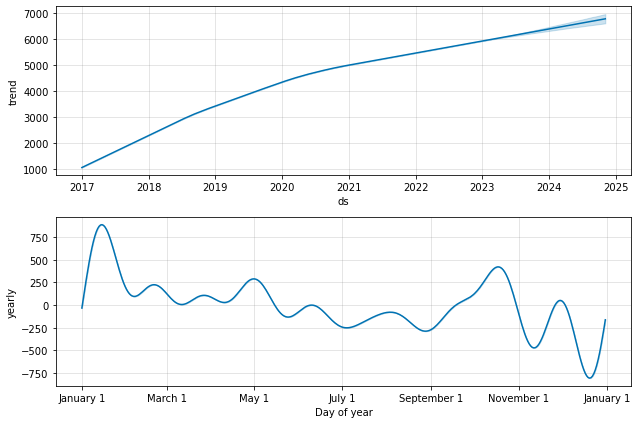

In [17]:
fig2 = m.plot_components(forecast)


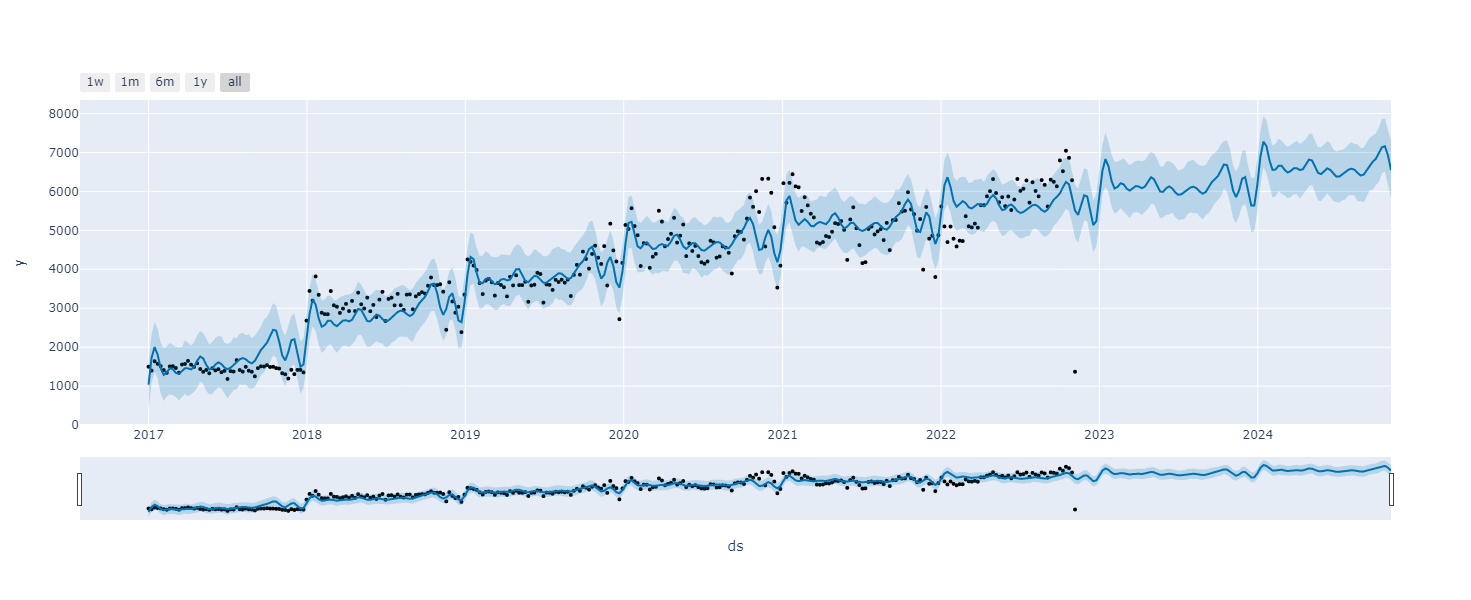

In [18]:
fig = plot_plotly(m, forecast)
plot_plotly(m, forecast)

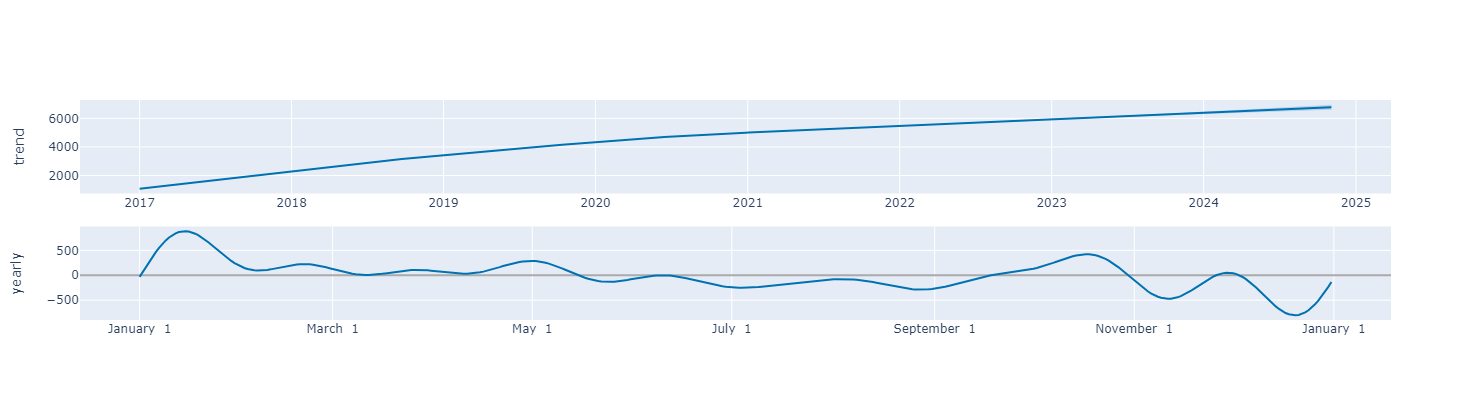

In [19]:
plot_components_plotly(m, forecast)


In [20]:
forecast.tail(3)

ds        trend   yhat_lower   yhat_upper  trend_lower  \
407 2024-10-20  6759.606846  6511.420117  7870.254820  6590.759473   
408 2024-10-27  6768.474427  6198.030383  7616.850995  6597.473472   
409 2024-11-03  6777.342009  5837.384989  7299.485011  6604.489860   

     trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
407  6935.953924      400.504347            400.504347            400.504347   
408  6946.811094      157.475124            157.475124            157.475124   
409  6959.390437     -232.818872           -232.818872           -232.818872   

         yearly  yearly_lower  yearly_upper  multiplicative_terms  \
407  400.504347    400.504347    400.504347                   0.0   
408  157.475124    157.475124    157.475124                   0.0   
409 -232.818872   -232.818872   -232.818872                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper         yhat  
407                         0.0                         0.0  7160.111193  
408                         0.0                         0.0  6925.949552  
409                         0.0                         0.0  6544.523137

#### Cross Validation

In [21]:
# create cross-validation df
df_cv = cross_validation(m, initial='1461 days', period='14 days', horizon = '30 days')
df_cv.head(3)

INFO:prophet:Making 47 forecasts with cutoffs between 2021-01-01 00:00:00 and 2022-10-07 00:00:00


  0%|          | 0/47 [00:00<?, ?it/s]

ds         yhat   yhat_lower   yhat_upper       y     cutoff
0 2021-01-03  5507.576229  5009.211029  5947.739692  6210.0 2021-01-01
1 2021-01-10  6234.084623  5771.095618  6704.669596  5708.0 2021-01-01
2 2021-01-17  6423.231152  5958.686078  6864.388407  6218.0 2021-01-01

In [22]:
# create performance metrics df
df_p = performance_metrics(df_cv)
df_p.head(3)

horizon            mse        rmse         mae      mape     mdape  \
0  2 days  401201.050972  633.404335  515.121940  0.099187  0.081821   
1  9 days  439235.015492  662.748078  540.974142  0.101360  0.092166   
2 16 days  493533.380686  702.519310  575.548877  0.110338  0.094237   

      smape  coverage  
0  0.096289  0.531915  
1  0.099297  0.468085  
2  0.107107  0.489362

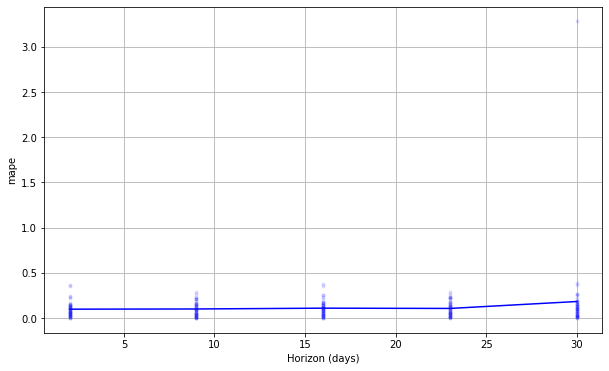

In [23]:
# plot cross-validation
fig = plot_cross_validation_metric(df_cv, metric='mape')

### SQL Export

In [24]:
ods = db.oracle('cco_wfm',oracle_wfm_key)
# add filename as column
team = file.split('.')[0]
forecast = forecast.merge(weekly_data, on='ds',how='left')
forecast = forecast.merge(weekly_for, on='ds',how='left')
forecast['Team'] = team

# determine last row
last_row = forecast['ds'].max()
end_date = f"'{last_row}'"

# remove duplicate rows before insert
delete = f'''DELETE FROM
                    "CCO_WFM"."Forecasts_Weekly" "A1"
                WHERE
                    ("A1"."Team" = '{team}')'''

with ods as conn:
    conn.execute(delete)

In [25]:
forecast['prophet_absolute_percent_error'] = ((forecast['y'] - forecast['yhat']) / forecast['y'])
forecast['verint_absolute_percent_error'] = ((forecast['y'] - forecast['for_y']) / forecast['y'])
forecast

ds        trend   yhat_lower   yhat_upper  trend_lower  \
0   2017-01-01  1069.776554   394.150475  1636.256314  1069.776554   
1   2017-01-08  1093.359720  1075.720526  2326.155821  1093.359720   
2   2017-01-15  1116.942885  1363.499918  2653.172068  1116.942885   
3   2017-01-22  1140.526050  1189.752865  2467.947622  1140.526050   
4   2017-01-29  1164.109216   809.232493  2110.071675  1164.109216   
..         ...          ...          ...          ...          ...   
405 2024-10-06  6741.871683  6236.434500  7632.096458  6577.957290   
406 2024-10-13  6750.739264  6464.005235  7863.164284  6584.352920   
407 2024-10-20  6759.606846  6511.420117  7870.254820  6590.759473   
408 2024-10-27  6768.474427  6198.030383  7616.850995  6597.473472   
409 2024-11-03  6777.342009  5837.384989  7299.485011  6604.489860   

     trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0    1069.776554      -32.692710            -32.692710            -32.692710   
1    1093.359720      631.975518            631.975518            631.975518   
2    1116.942885      886.303510            886.303510            886.303510   
3    1140.526050      664.082618            664.082618            664.082618   
4    1164.109216      288.423538            288.423538            288.423538   
..           ...             ...                   ...                   ...   
405  6912.669121      227.326484            227.326484            227.326484   
406  6925.274850      382.178653            382.178653            382.178653   
407  6935.953924      400.504347            400.504347            400.504347   
408  6946.811094      157.475124            157.475124            157.475124   
409  6959.390437     -232.818872           -232.818872           -232.818872   

         yearly  ...  yearly_upper  multiplicative_terms  \
0    -32.692710  ...    -32.692710                   0.0   
1    631.975518  ...    631.975518                   0.0   
2    886.303510  ...    886.303510                   0.0   
3    664.082618  ...    664.082618                   0.0   
4    288.423538  ...    288.423538                   0.0   
..          ...  ...           ...                   ...   
405  227.326484  ...    227.326484                   0.0   
406  382.178653  ...    382.178653                   0.0   
407  400.504347  ...    400.504347                   0.0   
408  157.475124  ...    157.475124                   0.0   
409 -232.818872  ...   -232.818872                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper         yhat  \
0                           0.0                         0.0  1037.083844   
1                           0.0                         0.0  1725.335238   
2                           0.0                         0.0  2003.246395   
3                           0.0                         0.0  1804.608669   
4                           0.0                         0.0  1452.532753   
..                          ...                         ...          ...   
405                         0.0                         0.0  6969.198167   
406                         0.0                         0.0  7132.917917   
407                         0.0                         0.0  7160.111193   
408                         0.0                         0.0  6925.949552   
409                         0.0                         0.0  6544.523137   

          y   for_y                Team prophet_absolute_percent_error  \
0    1498.0  1361.0  wireline_retention                       0.307688   
1    1399.0  1616.0  wireline_retention                      -0.233263   
2    1638.0  1446.0  wireline_retention                      -0.222983   
3    1572.0  1580.0  wireline_retention                      -0.147970   
4    1513.0  5477.0  wireline_retention                       0.039965   
..      ...     ...                 ...                            ...   
405     NaN     NaN  wireline_retention                   

In [26]:
ods = db.oracle('cco_wfm',oracle_wfm_key)
# Import forecast to database
rows_imported = 0
start_time = time.time()

cols = forecast.dtypes[forecast.dtypes=='object'].index
type_mapping = {col : String(100) for col in cols }

print(f'importing rows {rows_imported} to {rows_imported + len(forecast)}...', end='')
forecast.to_sql('Forecasts_Weekly',ods,schema='CCO_WFM',if_exists='append',index=False,dtype=type_mapping)
rows_imported += len(df)

end_time = time.time() - start_time
print(f'Done. {end_time} total seconds have elapsed.')

importing rows 0 to 410...Done. 0.12999868392944336 total seconds have elapsed.


## AHT Forecasts

In [27]:
appended_data['Adj_AHT'] = appended_data['Actual_AHT'] * appended_data['Actual_CV']
appended_data['Adj_AHT'] = appended_data['Adj_AHT'].replace(0, np.nan)
grouped_aht = appended_data.groupby(['DateTime'])['Adj_AHT'].sum()
grouped_aht = grouped_aht.reset_index()
grouped_aht.head(3)

DateTime  Adj_AHT
0 2017-01-02 07:00:00      0.0
1 2017-01-02 07:15:00      0.0
2 2017-01-02 07:30:00    786.0

In [28]:
hourly_aht = grouped_aht.resample('1H', on='DateTime').sum()
hourly_aht.head(3)

Adj_AHT
DateTime                    
2017-01-02 07:00:00   1572.0
2017-01-02 08:00:00  11783.0
2017-01-02 09:00:00  27988.0

In [29]:
hourly_aht.reset_index(inplace=True)
daily_aht = hourly_aht.resample('D', on='DateTime').sum()
daily_aht.head(3)

Adj_AHT
DateTime            
2017-01-02  174094.0
2017-01-03  232600.0
2017-01-04  184493.0

In [30]:
daily_aht.reset_index(inplace=True)
weekly_aht = daily_aht.resample('W', label='left', on='DateTime').sum()
weekly_aht.tail(3)

Adj_AHT
DateTime             
2022-10-23  5485783.0
2022-10-30  4837624.0
2022-11-06  1083346.0

In [31]:
weekly_cv.tail(3)

Actual_CV
DateTime             
2022-10-23     6860.0
2022-10-30     6287.0
2022-11-06     1370.0

In [32]:
combined_aht = weekly_aht.drop(columns=['Adj_AHT'])
combined_aht['Actual_AHT'] = weekly_aht['Adj_AHT'] / weekly_cv['Actual_CV']
column_names = ['ds','y']
weekly_data = combined_aht.reset_index()
weekly_data.columns = column_names
weekly_data.tail(3)

ds           y
303 2022-10-23  799.676822
304 2022-10-30  769.464610
305 2022-11-06  790.763504

In [33]:
appended_data['Adj_for'] = appended_data['Forecasted_AHT'] * appended_data['Forecasted_CV']
appended_data['Adj_for'] = appended_data['Adj_for'].replace(0, np.nan)
grouped_for = appended_data.groupby(['DateTime'])['Adj_for'].sum()
grouped_for = grouped_for.reset_index()
grouped_for.head(3)

DateTime  Adj_for
0 2017-01-02 07:00:00    990.0
1 2017-01-02 07:15:00    836.0
2 2017-01-02 07:30:00   1671.0

In [34]:
hourly_faht = grouped_for.resample('1H', on='DateTime').sum()
hourly_faht.head(3)

Adj_for
DateTime                    
2017-01-02 07:00:00   5873.0
2017-01-02 08:00:00  10511.0
2017-01-02 09:00:00  15549.0

In [35]:
hourly_faht.reset_index(inplace=True)
daily_faht = hourly_faht.resample('D', on='DateTime').sum()
daily_faht.head(3)

Adj_for
DateTime            
2017-01-02  133245.0
2017-01-03  198744.0
2017-01-04  165157.0

In [36]:
daily_faht.reset_index(inplace=True)
weekly_faht = daily_faht.resample('W', label='left', on='DateTime').sum()
weekly_faht.tail(3)

Adj_for
DateTime             
2022-10-23  5679170.0
2022-10-30  5752754.0
2022-11-06  1341268.0

In [37]:
weekly_fcv.tail(3)

Forecasted_CV
DateTime                 
2022-10-23         6481.0
2022-10-30         6680.0
2022-11-06         1490.0

In [38]:
combined_for = weekly_faht.drop(columns=['Adj_for'])
combined_for['Forecasted_AHT'] = weekly_faht['Adj_for'] / weekly_fcv['Forecasted_CV']
column_names = ['ds','for_y']
weekly_for_aht = combined_for.reset_index()
weekly_for_aht.columns = column_names
weekly_for_aht.tail(3)

ds       for_y
303 2022-10-23  876.279895
304 2022-10-30  861.190719
305 2022-11-06  900.179866

#### Initiate Prophet

In [39]:
df = weekly_data
m = Prophet() 
m.fit(df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [40]:
future = m.make_future_dataframe(periods=104, freq='W')
future.tail(3)

ds
407 2024-10-20
408 2024-10-27
409 2024-11-03

In [41]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(3)


ds        yhat  yhat_lower  yhat_upper
407 2024-10-20  746.557326  650.505354  839.467822
408 2024-10-27  737.669748  645.488254  839.652835
409 2024-11-03  729.788518  626.726702  824.048966

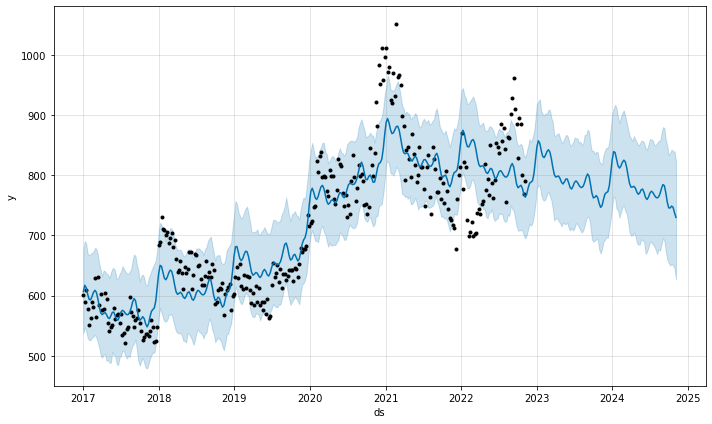

In [42]:
fig1 = m.plot(forecast)

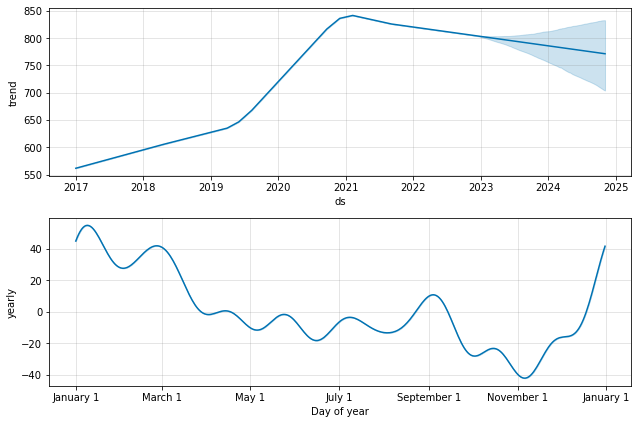

In [43]:
fig2 = m.plot_components(forecast)


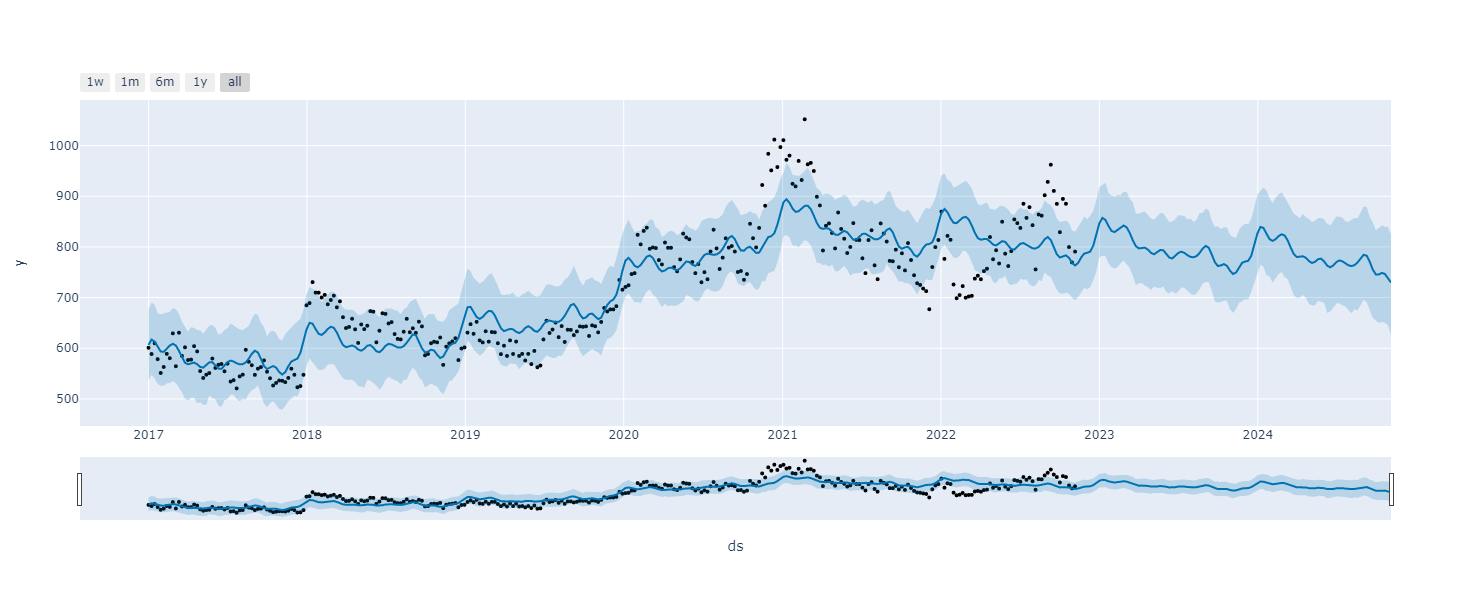

In [44]:
fig = plot_plotly(m, forecast)
plot_plotly(m, forecast)

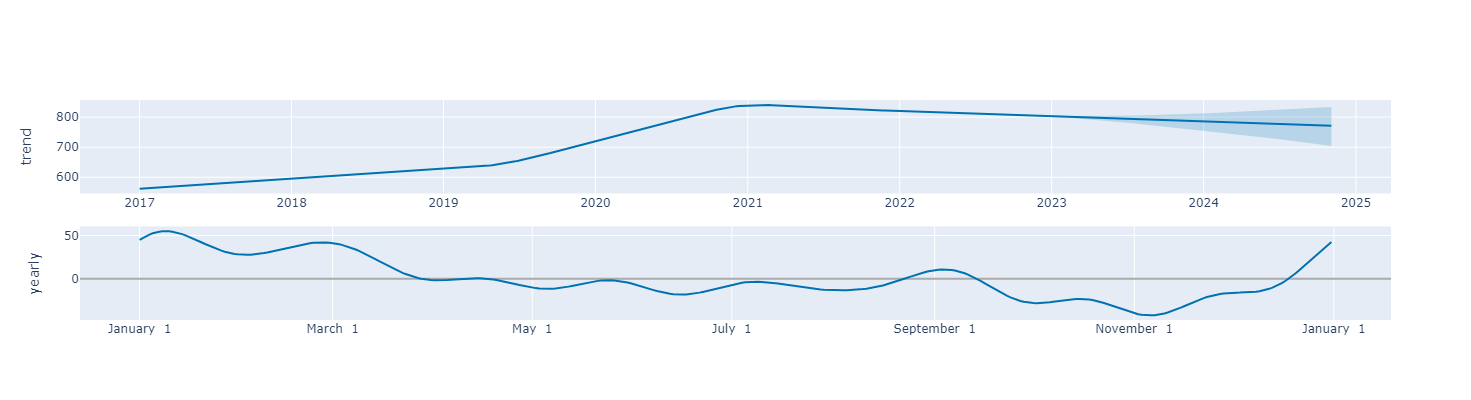

In [45]:
plot_components_plotly(m, forecast)


In [46]:
forecast.tail(3)

ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
407 2024-10-20  771.935753  650.505354  839.467822   706.635100   832.439094   
408 2024-10-27  771.605808  645.488254  839.652835   705.066208   832.604424   
409 2024-11-03  771.275864  626.726702  824.048966   704.003419   832.606914   

     additive_terms  additive_terms_lower  additive_terms_upper     yearly  \
407      -25.378427            -25.378427            -25.378427 -25.378427   
408      -33.936060            -33.936060            -33.936060 -33.936060   
409      -41.487346            -41.487346            -41.487346 -41.487346   

     yearly_lower  yearly_upper  multiplicative_terms  \
407    -25.378427    -25.378427                   0.0   
408    -33.936060    -33.936060                   0.0   
409    -41.487346    -41.487346                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper        yhat  
407                         0.0                         0.0  746.557326  
408                         0.0                         0.0  737.669748  
409                         0.0                         0.0  729.788518

#### Cross Validate

In [47]:
# create cross-validation df
df_cv = cross_validation(m, initial='1461 days', period='14 days', horizon = '30 days')
df_cv.head(3)

INFO:prophet:Making 47 forecasts with cutoffs between 2021-01-01 00:00:00 and 2022-10-07 00:00:00


  0%|          | 0/47 [00:00<?, ?it/s]

ds        yhat  yhat_lower   yhat_upper            y     cutoff
0 2021-01-03  951.195318  911.742915   989.679633  1010.680837 2021-01-01
1 2021-01-10  966.610266  926.188498  1005.795545   971.924142 2021-01-01
2 2021-01-17  970.528590  930.924091  1009.038283   980.083789 2021-01-01

In [48]:
# create performance metrics df
df_p = performance_metrics(df_cv)
df_p.head(3)

horizon           mse        rmse        mae      mape     mdape     smape  \
0  2 days   8558.605819   92.512733  80.221287  0.097600  0.092583  0.098832   
1  9 days   9567.315503   97.812655  81.871370  0.100768  0.103038  0.100853   
2 16 days  11485.471044  107.170290  93.730626  0.114585  0.111235  0.115897   

   coverage  
0  0.255319  
1  0.297872  
2  0.234043

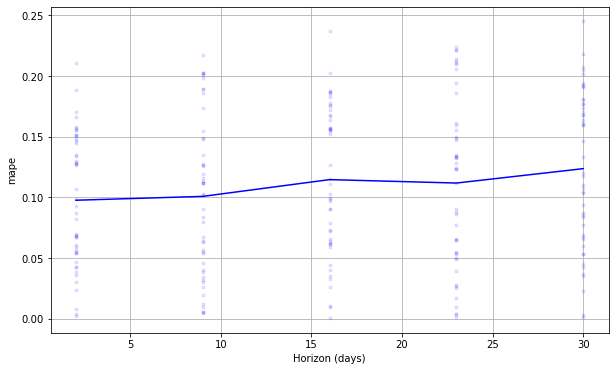

In [49]:
# plot cross-validation
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [50]:
ods = db.oracle('cco_wfm',oracle_wfm_key)
# add filename as column
team = file.split('.')[0]
forecast = forecast.merge(weekly_data, on='ds',how='left')
forecast = forecast.merge(weekly_for_aht, on='ds',how='left')
forecast['Team'] = team

# determine last row
last_row = forecast['ds'].max()
end_date = f"'{last_row}'"

# remove duplicate rows before insert
delete = f'''DELETE FROM
                    "CCO_WFM"."Forecasts_Weekly_AHT" "A1"
                WHERE
                    ("A1"."Team" = '{team}')'''

with ods as conn:
    conn.execute(delete)

In [51]:
forecast['prophet_absolute_percent_error'] = ((forecast['y'] - forecast['yhat']) / forecast['y'])
forecast['verint_absolute_percent_error'] = ((forecast['y'] - forecast['for_y']) / forecast['y'])
forecast

ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0   2017-01-01  561.548533  537.292853  676.498923   561.548533   561.548533   
1   2017-01-08  562.197283  547.212227  690.569019   562.197283   562.197283   
2   2017-01-15  562.846032  540.798658  685.885813   562.846032   562.846032   
3   2017-01-22  563.494782  529.404742  669.243798   563.494782   563.494782   
4   2017-01-29  564.143531  525.745509  667.144239   564.143531   564.143531   
..         ...         ...         ...         ...          ...          ...   
405 2024-10-06  772.595642  649.997954  837.152299   709.666315   831.480951   
406 2024-10-13  772.265697  651.965299  842.612324   708.150707   832.182611   
407 2024-10-20  771.935753  650.505354  839.467822   706.635100   832.439094   
408 2024-10-27  771.605808  645.488254  839.652835   705.066208   832.604424   
409 2024-11-03  771.275864  626.726702  824.048966   704.003419   832.606914   

     additive_terms  additive_terms_lower  additive_terms_upper     yearly  \
0         44.960778             44.960778             44.960778  44.960778   
1         54.805474             54.805474             54.805474  54.805474   
2         50.192176             50.192176             50.192176  50.192176   
3         38.454994             38.454994             38.454994  38.454994   
4         29.427398             29.427398             29.427398  29.427398   
..              ...                   ...                   ...        ...   
405      -27.046628            -27.046628            -27.046628 -27.046628   
406      -23.531150            -23.531150            -23.531150 -23.531150   
407      -25.378427            -25.378427            -25.378427 -25.378427   
408      -33.936060            -33.936060            -33.936060 -33.936060   
409      -41.487346            -41.487346            -41.487346 -41.487346   

     ...  yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
0    ...     44.960778                   0.0                         0.0   
1    ...     54.805474                   0.0                         0.0   
2    ...     50.192176                   0.0                         0.0   
3    ...     38.454994                   0.0                         0.0   
4    ...     29.427398                   0.0                         0.0   
..   ...           ...                   ...                         ...   
405  ...    -27.046628                   0.0                         0.0   
406  ...    -23.531150                   0.0                         0.0   
407  ...    -25.378427                   0.0                         0.0   
408  ...    -33.936060                   0.0                         0.0   
409  ...    -41.487346                   0.0                         0.0   

     multiplicative_terms_upper        yhat           y       for_y  \
0                           0.0  606.509312  600.829105  596.383542   
1                           0.0  617.002756  588.551823  619.050124   
2                           0.0  613.038208  609.770452  605.069848   
3                           0.0  601.949775  578.389949  596.025316   
4                           0.0  593.570929  551.159947  583.407157   
..                          ...         ...         ...         ...   
405                         0.0  745.549014         NaN         NaN   
406                         0.0  748.734547         NaN         NaN   
407                         0.0  746.557326         NaN         NaN   
408                         0.0  737.669748         NaN         NaN   
409                         0.0  729.788518         NaN         NaN   

                   Team prophet_absolute_percent_error  \
0    wireline_retention                      -0.009454   
1    wireline_retention                      -0.048341   
2    wireline_retention                      -0.005359   
3    wireline_retention                      -0.040733   
4    wireline_retention                      -0.076949   


In [52]:
ods = db.oracle('cco_wfm',oracle_wfm_key)
# Import forecast to database
rows_imported = 0
start_time = time.time()

cols = forecast.dtypes[forecast.dtypes=='object'].index
type_mapping = {col : String(100) for col in cols }

print(f'importing rows {rows_imported} to {rows_imported + len(forecast)}...', end='')
forecast.to_sql('Forecasts_Weekly_AHT',ods,schema='CCO_WFM',if_exists='append',index=False,dtype=type_mapping)
rows_imported += len(df)

end_time = time.time() - start_time
print(f'Done. {end_time} total seconds have elapsed.')

importing rows 0 to 410...Done. 0.10100269317626953 total seconds have elapsed.
